In [29]:
###MNIST 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split 

import torch 
import torch.nn as nn 
from torchvision import transforms,models 

from torch.autograd import Variable 
import torch.optim as optim 
import torch.nn.functional as F 
import os 
path='./data/mnist/'
print(path)

./data/mnist/


In [30]:
train=pd.read_csv(os.path.join(path+'train.csv'),dtype=np.float32)
final_test=pd.read_csv(os.path.join(path+'test.csv'),dtype=np.float32)
train.label.head()

0    1.0
1    0.0
2    1.0
3    4.0
4    0.0
Name: label, dtype: float32

In [31]:
print(train.head())
print(train.describe())
print(train.info())


   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0    1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2    1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
1     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
2     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
3     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
4     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   

   pixel780  pixel781  pixel782  pixel783  
0       0.0       0.0       0.

In [32]:
target_np=train.label.values 
feature_np=train.loc[:,train.columns!='label'].values/255
features_train,features_test,target_train,target_test=train_test_split(feature_np,target_np,test_size=0.2,random_state=42)


In [33]:
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
featuresTrain=torch.from_numpy(features_train)
targetTrain=torch.from_numpy(target_train).type(torch.LongTensor)
print(featuresTrain.shape)
print(targetTrain.shape)

torch.Size([33600, 784])
torch.Size([33600])


In [35]:
featuresTest=torch.from_numpy(features_test)
targetTest=torch.from_numpy(target_test).type(torch.LongTensor)
batch_size=256
train=torch.utils.data.TensorDataset(featuresTrain,targetTrain)
test=torch.utils.data.TensorDataset(featuresTest,targetTest)
#data loader

train_loader=torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True)


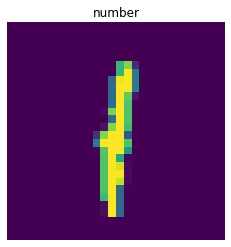

In [36]:
# visualize one of image in data set 
def visualize_image(data,index,pred=False,val=0):
    plt.imshow(data[index].reshape(28,28))
    plt.axis('off')
    plt.title('number')
    plt.show()
visualize_image(feature_np,12)

In [37]:
featuresTrain.shape

torch.Size([33600, 784])

In [40]:
# class Classifier(nn.Module):
#     def __init(self):
#         super().__init__()
#         #5hidden layer 
#         self.fc1=nn.Linear(28*28,512)
#         self.fc2=nn.Linear(512,256)
#         self.fc3=nn.Linear(256,128)
#         self.fc4=nn.Linear(128,64)
#         self.fc5=nn.Linear(64,10)
#         self.dropout=nn.Dropout(p=0.2)
#         self.log_softmax=F.log_softmax
#         self.Relu=F.relu
#         self.layer=nn.Sequential(
#             self.fc1,
#             self.dropout,
#             self.Relu.
#             self.fc2,
#             self.dropout.
#             self.Relu,
#             self.fc3,
#             self.dropout,
#             self.Relu,
#             self.fc4,
#             self.dropout,
#             self.Relu,
#             self.fc5,
#             self.log_softmax
            
#         )

#     def forward(self,x ):
#         for layer in self.layer:
#             x=layer(x)
#         return x
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2)
        # Add softmax on output layer
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = self.log_softmax(self.fc5(x), dim=1)
        
        return x


In [44]:
model=Classifier()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-3)

epochs=25
steps=0
train_losses,test_losses=[],[]

for e in range(epochs):
    running_loss=0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        if steps%50==0:
            test_loss=0
            accuracy=0

            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    log_ps=model(images)
                    test_loss +=criterion(log_ps,labels)

                    ps=torch.exp(log_ps)
                    top_p,top_class=ps.topk(1,dim=1)
                    equals=top_class==labels.view(*top_class.shape)
                    accuracy+=torch.mean(equals.type(torch.FloatTensor))
            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))




Epoch: 1/25..  Training Loss: 0.489..  Test Loss: 0.478..  Test Accuracy: 0.851
Epoch: 1/25..  Training Loss: 0.670..  Test Loss: 0.320..  Test Accuracy: 0.901
Epoch: 2/25..  Training Loss: 0.040..  Test Loss: 0.244..  Test Accuracy: 0.927
Epoch: 2/25..  Training Loss: 0.142..  Test Loss: 0.197..  Test Accuracy: 0.940
Epoch: 2/25..  Training Loss: 0.224..  Test Loss: 0.176..  Test Accuracy: 0.948
Epoch: 3/25..  Training Loss: 0.049..  Test Loss: 0.153..  Test Accuracy: 0.952
Epoch: 3/25..  Training Loss: 0.114..  Test Loss: 0.139..  Test Accuracy: 0.958
Epoch: 4/25..  Training Loss: 0.004..  Test Loss: 0.141..  Test Accuracy: 0.958
Epoch: 4/25..  Training Loss: 0.051..  Test Loss: 0.122..  Test Accuracy: 0.965
Epoch: 4/25..  Training Loss: 0.099..  Test Loss: 0.114..  Test Accuracy: 0.967
Epoch: 5/25..  Training Loss: 0.019..  Test Loss: 0.131..  Test Accuracy: 0.961
Epoch: 5/25..  Training Loss: 0.058..  Test Loss: 0.106..  Test Accuracy: 0.967
Epoch: 5/25..  Training Loss: 0.093..  T

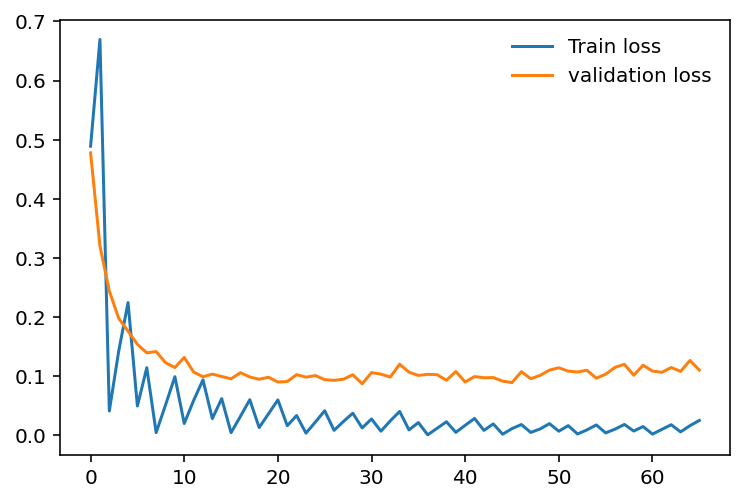

In [48]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(train_losses,label='Train loss')
plt.plot(test_losses,label='validation loss')
plt.legend(frameon=False)


In [53]:
def view_classify(img, ps):
    ps=ps.data.numpy().squeeze()

    fig,(ax1,ax2)=plt.subplots(figsize=(6,9),ncols=2)
    ax1.imshow(img.resize(1,28,28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10),ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('class')
    ax2.set_xlim(0,1.1)
    plt.tight_layout()


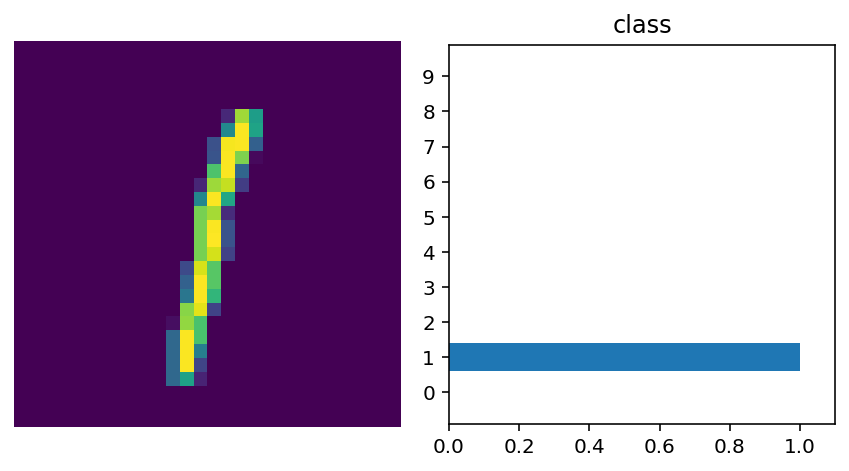

In [54]:
%matplotlib inline
def make_predictions(data):
    images,labels=next(iter(data))
    img=images[42].view(1,784)
    # Turn off gradients to speed up this part 
    with torch.no_grad():
        logps=model(img)
    
    #output of the network are log_probabilities need to take exponential for probabilites

    ps= torch.exp(logps)
    view_classify(img.view(1,28,28),ps)
make_predictions(test_loader)

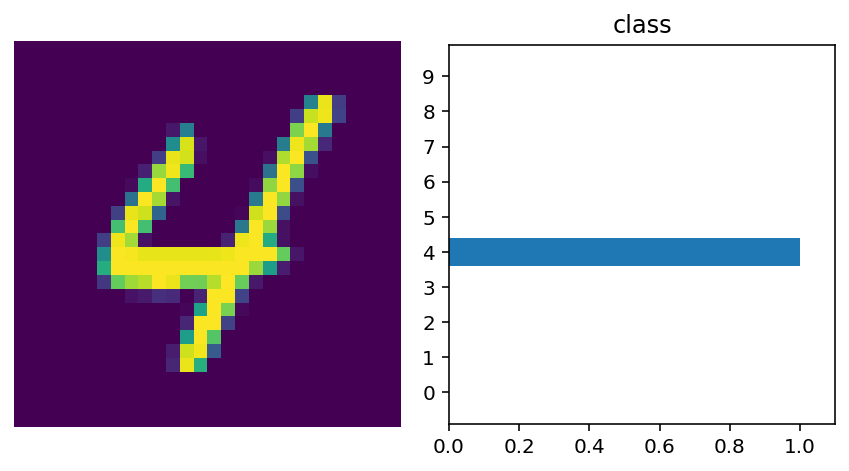

In [56]:
###preparing Test Data for prediction 

final_test_np=final_test.values/255
test_tn=torch.from_numpy(final_test_np)

fake_labels=np.zeros(final_test_np.shape)
fake_labels=torch.from_numpy(fake_labels)

submission_tn_data=torch.utils.data.TensorDataset(test_tn,fake_labels)

submission_loader=torch.utils.data.DataLoader(submission_tn_data,batch_size=batch_size,shuffle=False)

make_predictions(submission_loader)

In [59]:
submission=[['ImageId','Label']]

with torch.no_grad():
    model.eval()
    image_id=1
    for images, _ in submission_loader:
        log_ps=model(images)
        ps=torch.exp(log_ps)
        top_p,top_class=ps.topk(1,dim=1)

        for predictions in top_class:
            submission.append([image_id,predictions.item()])
            image_id+=1


submission_df=pd.DataFrame(submission)
submission_df.columns=submission_df.iloc[0]
submission_df=submission_df.drop(0,axis=0)

submission_df.to_csv('submission.csv',index=False)